In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Use inspector to print column names and types
inspector=inspect(engine)
inspector.get_table_names()

columns_m=inspector.get_columns('measurement')
for column in columns_m:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
#Last Date
descendingdate=session.query(Measurement).order_by(Measurement.date.desc()).first()
descendingdate.__dict__
#1 Year from Last Date
year_ago=dt.date(2017,8,23)-dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date (order_by)
within_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date.asc()).statement
# Save the query results as a Pandas DataFrame
dataframe = pd.read_sql_query(within_year, session.bind)
dataframe.head(10)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
7,2016-08-24,0.08
8,2016-08-24,2.15
9,2016-08-24,2.28


In [13]:
#Set the index to the date column
dataframe.set_index("date")

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [14]:
#For dates with multiple pcrp values, calculate the average of these values
avg_prcp=dataframe.groupby("date").mean()
avg_prcp

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


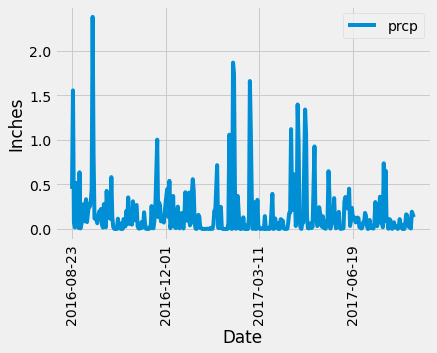

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=avg_prcp.plot(rot=90)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.show()

In [16]:
avg_prcp.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(func.count(Station.station)).all()
stationcount

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_entries = session.query(Measurement.station, func.count(Measurement.station)).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).all()
station_entries

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Most active station
station_active = session.query(Measurement.station, func.count(Measurement.station)).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).limit(1).all()
station_active

[('USC00519281', 2772)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_min = session.query(Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()
print(station_min)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [21]:
# Choose the station with the highest number of temperature observations.
station_max_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).\
        order_by(func.count(Measurement.tobs).desc()).\
        group_by(Measurement.station).limit(1).all()
station_max_temp_obs

[('USC00519281', 2772)]

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_9281 = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= year_ago).statement


In [25]:
# Save the query results as a Pandas DataFrame
station_9281_df = pd.read_sql_query(station_9281, session.bind)
station_9281_df.head(10)

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
5,2016-08-28,73.0
6,2016-08-29,78.0
7,2016-08-30,77.0
8,2016-08-31,78.0
9,2016-09-01,80.0


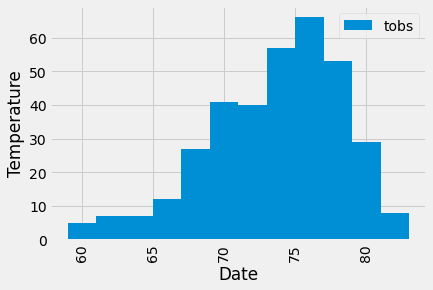

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=station_9281_df.plot.hist(rot=90, bins=12)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
